---
title: Borzoi CAGE test
author: Sabrina Mi
date: 8/26/2023
description: "A 3-way comparison of Enformer/Borzoi prediction models against observed gene expression in human brain tissue. Correlation tests support the Borzoi paper's claims, we report Spearman correlations of (1) R = 0.856 for Borzoi GTEx, (2) R = 0.807 for Borzoi CAGE, and (3) R = 0.796 for Enformer CAGE tracks against observed gene expression"
---

We ran the Borzoi human track models on the same genes as the GTEx track runs to compare the performance.

In [3]:
import pandas as pd
annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.gene.txt", sep="\t")
gene_list = pd.read_csv("/home/s1mi/enformer_rat_data/output/hg38_borzoi_across_genes.csv", header=None)
gene_list = gene_list.dropna()
gene_df = gene_list.merge(annot_df, left_on= 0, right_on = "ensembl_gene_id")
gene_df = gene_df[["ensembl_gene_id", "chromosome_name", "transcription_start_site"]]
gene_df.to_csv("gene_list.csv", header=False, index=False)

# Run Predictions

Each run can take anywhere from 2.5-5 GPU seconds, so allocate walltime accordingly. For my 981 gene regions, I requested `qsub -I -A AIHPC4EDU -l walltime=1:30:00 -l filesystems=home:grand -q preemptable`

```
module load conda
conda activate borzoi
cd /home/s1mi/Github/deep-learning-in-genomics/posts/2023-09-25-borzoi-CAGE-test
python borzoi_predict_CAGE.py --gene_df gene_list.csv --CAGE_tracks 610,611 
```

# Process Results

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
# read CAGE predictions
hg38_predictions = pd.read_csv("/home/s1mi/enformer_rat_data/output/hg38_borzoi_CAGE_test_predictions.csv", header=None)
# read GTEx predictions
gtex_predictions = pd.read_csv("/home/s1mi/enformer_rat_data/output/hg38_borzoi_across_genes.csv", header=None)
# read observed gene expression
human_brain_gex = pd.read_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_vs_observed_expression_all_GTEx_brain_tissues.csv", index_col=0).dropna()
# merge dataframes
merged_df = gtex_predictions.merge(human_brain_gex, left_on=0, right_index=True, how="inner")
merged_df = merged_df[[0, 4, "enformer", "cortex"]]
merged_df.columns=["Gene", "Borzoi (GTEx)", "Enformer (CAGE)", "Observed"]
merged_df = merged_df.merge(hg38_predictions, left_on="Gene", right_on=0, how ="inner")

In [6]:
merged_df = merged_df[["Gene", "Borzoi (GTEx)", 3, "Enformer (CAGE)", "Observed"]]
merged_df.columns = ["Gene", "Borzoi (GTEx)", "Borzoi (CAGE)", "Enformer (CAGE)", "Observed"]
# Write to File
merged_df.to_csv("/home/s1mi/enformer_rat_data/output/hg38_borzoi_vs_enformer_test_predictions.csv", header = True,index = False)

We have 3 different prediction methods to evaluate, the outputs are combined in the following table:

In [7]:
merged_df

,Gene,Borzoi (GTEx),Borzoi (CAGE),Enformer (CAGE),Observed
0,ENSG00000260286,6.873438e+02,0.002146,0.005209,0.086014
1,ENSG00000162877,3.553310e+03,0.174000,0.270328,0.128466
2,ENSG00000083845,9.018748e+06,1.906000,18.964096,135.113922
3,ENSG00000143199,1.511829e+03,0.019640,0.049658,0.256258
4,ENSG00000188522,8.282543e+04,0.777000,0.083827,0.460673
...,...,...,...,...,...
968,ENSG00000198626,3.959017e+04,2.357000,11.577308,8.737213
969,ENSG00000184206,8.352521e+03,0.006187,0.002583,0.155200
970,ENSG00000140043,3.883056e+04,0.748500,5.710264,7.826176
971,ENSG00000081248,3.480795e+03,0.037500,0.021962,0.345895


# Plot Correlations

The correlation tables validate two key claims from the Borzoi paper:

1. Borzoi performs comparably, if not better, than Enformer on shared ENCODE tracks
2. Borzoi's RNA-seq coverage metric for gene expression correlates higher than CAGE predictions from both Borzoi and Enformer 
    - This correlation is biased because Borzoi was trained on some GTEx data
    - We need to validate on new data (GEUVADIS, HS rats, ...)

Although this experiment was tested on N=981 randomly selected genes, I believe this sample decently reflects how the Enformer/Borzoi methods would perform genome-wide. This subset has correlations similar to the full set of human genes when we look at the CAGE tracks, with Spearman R = 0.796 (subset) and R = 0.794 (all genes). 

**Pearson Correlations**

In [8]:
pearson_corr_df = merged_df.corr(method="pearson")
pearson_corr_df

,Borzoi (GTEx),Borzoi (CAGE),Enformer (CAGE),Observed
Borzoi (GTEx),1.000000,0.190700,0.225605,0.620217
Borzoi (CAGE),0.190700,1.000000,0.719421,0.469197
Enformer (CAGE),0.225605,0.719421,1.000000,0.593030
Observed,0.620217,0.469197,0.593030,1.000000


The low correlations between CAGE tracks (Enformer and Borzoi) and GTex tracks can be explained by non-linearity. We calculated RNA-seq coverage from a series of exponents, log transforms to better represent counts of transcripts, which can also explains why it has the highest correlation with observed GTEx TPM.

**Spearman Correlations**

In [22]:
spearman_corr_df = merged_df.corr(method="spearman")
spearman_corr_df

,Borzoi (GTEx),Borzoi (CAGE),Enformer (CAGE),Observed
Borzoi (GTEx),1.000000,0.843272,0.773361,0.856641
Borzoi (CAGE),0.843272,1.000000,0.888218,0.806720
Enformer (CAGE),0.773361,0.888218,1.000000,0.795909
Observed,0.856641,0.806720,0.795909,1.000000


### Plot against Observed

> All plots are comparing predicted and observed reference gene expression in human brain tissue, based off data from N=981 human genes. To account for outliers, we are plotting relative expression levels (rank) and the correlations shown are all Spearman R.

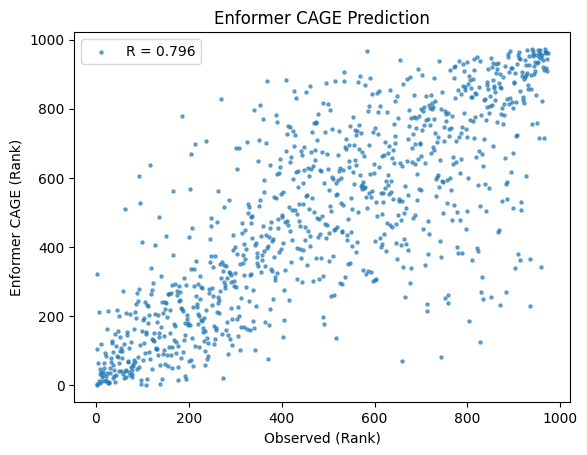

In [35]:
#| code-fold: true
x = merged_df["Observed"]
y = merged_df["Enformer (CAGE)"]
corr = spearman_corr_df.loc["Observed", "Enformer (CAGE)"]
plt.scatter(stats.rankdata(x), stats.rankdata(y), s=5, alpha=0.6, label=f'R = {corr:.3f}')
plt.xlabel('Observed (Rank)')
plt.ylabel('Enformer CAGE (Rank)')
plt.title("Enformer CAGE Prediction")
plt.legend()
plt.show()

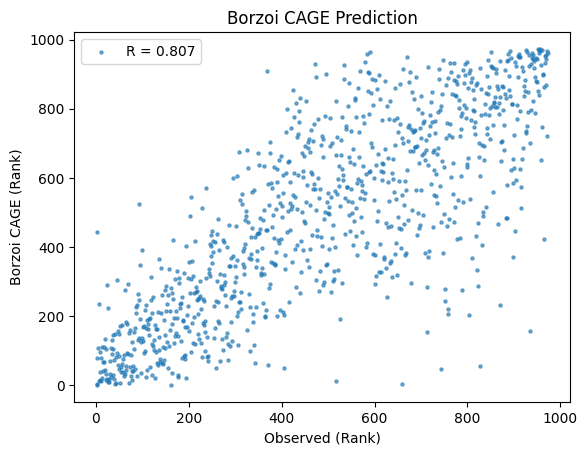

In [36]:
#| code-fold: true
x = merged_df["Observed"]
y = merged_df["Borzoi (CAGE)"]
corr = spearman_corr_df.loc["Observed", "Borzoi (CAGE)"]
plt.scatter(stats.rankdata(x), stats.rankdata(y), s=5, alpha=0.6, label=f'R = {corr:.3f}')
plt.xlabel('Observed (Rank)')
plt.ylabel('Borzoi CAGE (Rank)')
plt.title("Borzoi CAGE Prediction")
plt.legend()
plt.show()

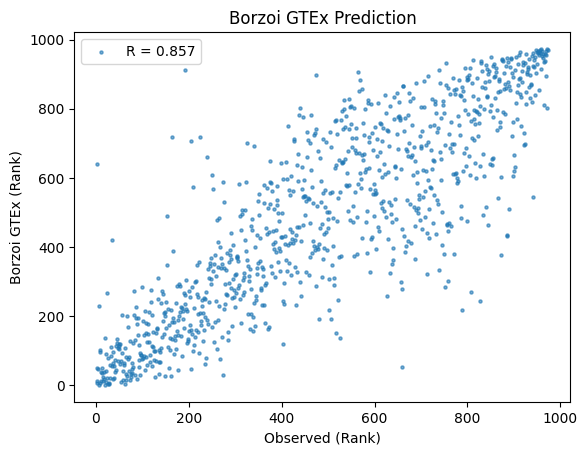

In [38]:
#| code-fold: true
x = merged_df["Observed"]
y = merged_df["Borzoi (GTEx)"]
corr = spearman_corr_df.loc["Observed", "Borzoi (GTEx)"]
plt.scatter(stats.rankdata(x), stats.rankdata(y), s=5, alpha=0.6, label=f'R = {corr:.3f}')
plt.xlabel('Observed (Rank)')
plt.ylabel('Borzoi GTEx (Rank)')
plt.title("Borzoi GTEx Prediction")
plt.legend()
plt.show()

## Extra Plots

Since Borzoi and Enformer CAGE tracks are measured on the same scale, it makes sense that the two have the highest pearson correlation out of all pairs. It's not clear why the plot looks curved though.

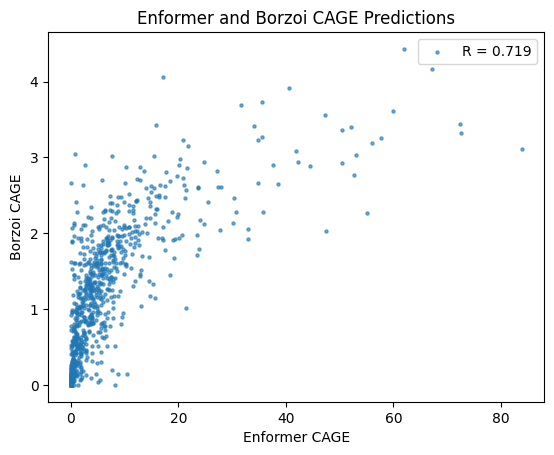

In [10]:
#| code-fold: true
x = merged_df["Enformer (CAGE)"]
y = merged_df["Borzoi (CAGE)"]
corr = pearson_corr_df.loc["Enformer (CAGE)", "Borzoi (CAGE)"]
plt.scatter(x, y, s=5, alpha=0.6, label=f'R = {corr:.3f}')
plt.xlabel('Enformer CAGE')
plt.ylabel('Borzoi CAGE')
plt.title("Enformer and Borzoi CAGE Predictions")
plt.legend()
plt.show()

Borzoi CAGE and GTEx had a large improvement from Pearson R = 0.191 to Spearman R = 0.843.

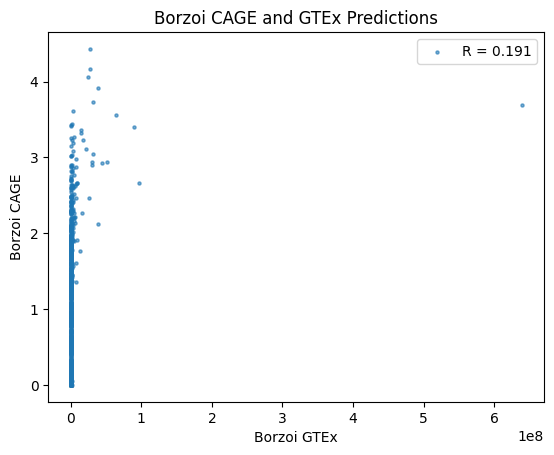

In [11]:
#| code-fold: true
x = merged_df["Borzoi (GTEx)"]
y = merged_df["Borzoi (CAGE)"]
corr = pearson_corr_df.loc["Borzoi (GTEx)", "Borzoi (CAGE)"]
plt.scatter(x, y, s=5, alpha=0.6, label=f'R = {corr:.3f}')
plt.xlabel('Borzoi GTEx')
plt.ylabel('Borzoi CAGE')
plt.title("Borzoi CAGE and GTEx Predictions")
plt.legend()
plt.show()